### 국회의원 현황정보 수집/분석/시각화/저장
* 이름과 ID 추출
* 상세페이지 정보 추출 (json으로 저장)
* 상세정보들을 DataFrame으로 변환
* 시각화(막대그래프,히스토그램, 파이챠트, 히트맵)
* 테이블로 저장

In [14]:
import requests
from bs4 import BeautifulSoup
import re

url = 'https://www.assembly.go.kr/assm/memact/congressman/memCond/memCondListAjax.do'
req_param_dict = {
    'currentPage':1,
    'rowPerPage':500
}
res = requests.get(url, params=req_param_dict)
print(res.status_code)
if res.ok:
    soup = BeautifulSoup(res.text, 'html.parser')
    print(len(soup.select('div.memberna_list dl dt a')))
    atag_list = soup.select('div.memberna_list dl dt a')
    
    member_id_list = []
    for atag in atag_list:
        href = atag['href']
        matched = re.search(r'(\d+)', href)        
        if matched:
            member_id = matched.group(0)
        member_id_list.append(member_id)
    print(len(member_id_list))        
    print(member_id_list[:3])

200
295
295
['9771230', '9771142', '9771174']


In [40]:
import requests
from bs4 import BeautifulSoup
import re
from urllib.parse import urljoin

print('===> 스크래핑 시작')
member_detail_list = []
for idx,mem_id in enumerate(member_id_list,1):
    detail_url = f'https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd={mem_id}'
    print(idx, detail_url)
    res = requests.get(detail_url)
    if res.ok:
        soup = BeautifulSoup(res.text, 'html.parser')
        
        #1명의 정보를 저장할 dict 선언
        member_detail_dict = {}
        
        dt_list = [dt_tag.text for dt_tag in soup.select('dl.pro_detail dt')]
        
        dd_list = []        
        for dd_tag in soup.select('dl.pro_detail dd'):
            pattern = re.compile(f'[\n\r\t]')
            dd_text = pattern.sub('',dd_tag.text.strip()).replace(" ","")
            dd_list.append(dd_text)
        
        member_detail_dict = dict(zip(dt_list, dd_list))
        
        for div_tag in soup.select('div.profile'):
            member_detail_dict['이름']=div_tag.find('h4').text
            
            img_tag = div_tag.select('img')
            if img_tag:
                member_detail_dict['이미지'] = urljoin(detail_url, img_tag[0]['src'])
            
            member_detail_dict['생년월일'] = div_tag.select_one('li:nth-of-type(4)').text
        
        #1명의 정보가 저장된 dict를 list에 추가하기
        member_detail_list.append(member_detail_dict)

print(len(member_detail_list))        
print('===> 스크래핑 끝')        

===> 스크래핑 시작
1 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771230
2 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771142
3 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771174
4 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771233
5 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771283
6 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9770933
7 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771116
8 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771276
9 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771168
10 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771007
11 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771109
12 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771180
13 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9770931
14 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771224
15 https://www.a

In [41]:
import json

with open('data/member.json','w') as file:
    json.dump(member_detail_list, file)

In [1]:
import pandas as pd

member_df = pd.read_json('data/member.json')
print(member_df.shape)

(295, 16)


In [43]:
member_df.head(2)

,정당,선거구,소속위원회,당선횟수,사무실 전화,사무실 호실,홈페이지,이메일,보좌관,비서관,비서,"취미, 특기",의원실 안내,이름,이미지,생년월일
0,국민의힘,경남창원시성산구,보건복지위원회,"재선(19대,21대)",02-784-1751,의원회관937호,http://blog.naver.com/ggotop,ggotop@naver.com,"김홍광,한영애","지상훈,최광림","김영록,안효상,이유진,홍지형,김지훈",,,강기윤,https://www.assembly.go.kr/photo/9771230.jpg,1960-06-04
1,국민의힘,대구동구을,"국방위원회,정치개혁특별위원회",초선(21대),02-784-5275,의원회관341호,,kds21341@naver.com,"박홍규,정운태","유진영,윤미라","박순권,김광연,김현정,송민욱",,,강대식,https://www.assembly.go.kr/photo/9771142.jpg,1959-11-02


In [45]:
member_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   정당      295 non-null    object
 1   선거구     295 non-null    object
 2   소속위원회   295 non-null    object
 3   당선횟수    295 non-null    object
 4   사무실 전화  295 non-null    object
 5   사무실 호실  295 non-null    object
 6   홈페이지    295 non-null    object
 7   이메일     295 non-null    object
 8   보좌관     295 non-null    object
 9   비서관     295 non-null    object
 10  비서      295 non-null    object
 11  취미, 특기  295 non-null    object
 12  의원실 안내  295 non-null    object
 13  이름      295 non-null    object
 14  이미지     295 non-null    object
 15  생년월일    295 non-null    object
dtypes: object(16)
memory usage: 37.0+ KB


In [47]:
member_df['정당'].unique()

array(['국민의힘', '더불어민주당', '정의당', '국민의당', '무소속', '기본소득당', '시대전환'],
      dtype=object)

In [49]:
member_df['정당'].value_counts()

더불어민주당    172
국민의힘      106
정의당         6
무소속         6
국민의당        3
기본소득당       1
시대전환        1
Name: 정당, dtype: int64

In [50]:
member_df['당선횟수'].value_counts()

초선(21대)                        149
재선(20대,21대)                     60
3선(19대,20대,21대)                 33
4선(17대,19대,20대,21대)             10
재선(19대,21대)                      9
5선(17대,18대,19대,20대,21대)          7
4선(18대,19대,20대,21대)              6
3선(18대,19대,21대)                  3
재선(17대,21대)                      2
4선(16대,17대,18대,21대)              2
5선(16대,17대,18대,20대,21대)          2
3선(17대,19대,21대)                  2
3선(18대,20대,21대)                  2
4선(17대,18대,19대,21대)              1
3선(15대,16대,21대)                  1
6선(16대,17대,18대,19대,20대,21대)      1
5선(16대,17대,18대,19대,21대)          1
5선(15대,16대,19대,20대,21대)          1
3선(17대,18대,21대)                  1
재선(18대,21대)                      1
5선(15대,16대,17대,18대,21대)          1
Name: 당선횟수, dtype: int64

In [52]:
member_df['선거구'].value_counts()

비례대표              47
경남창원시성산구           1
광주광산구갑             1
전남담양군함평군영광군장성군     1
강원원주시갑             1
                  ..
경남창원시의창구           1
충남천안시을             1
서울강북구을             1
부산남구을              1
서울양천구갑             1
Name: 선거구, Length: 249, dtype: int64

In [2]:
#당선횟수2 컬럼을 새로 추가
#재선(20대,21대) -> 재선
print(type(member_df['당선횟수']))
print(type(member_df['당선횟수'].str))
#Series객체를 StringMethods 객체로 변환(문자열 슬라이싱을 하기 위해서)
temp_str = member_df['당선횟수'].str
#2글자 슬라이싱 값을 당선횟수2 라는 컬럼으로 저장
member_df['당선횟수2'] = temp_str[:2]

member_df.loc[0:3,['당선횟수','당선횟수2']]

<class 'pandas.core.series.Series'>
<class 'pandas.core.strings.accessor.StringMethods'>


,당선횟수,당선횟수2
0,"재선(19대,21대)",재선
1,초선(21대),초선
2,초선(21대),초선
3,초선(21대),초선


In [56]:
member_df['당선횟수2'].value_counts()

초선    149
재선     72
3선     42
4선     19
5선     12
6선      1
Name: 당선횟수2, dtype: int64

In [57]:
#6선 국회의원 누구?
member_df.loc[member_df['당선횟수2'] == '6선']

,정당,선거구,소속위원회,당선횟수,사무실 전화,사무실 호실,홈페이지,이메일,보좌관,비서관,비서,"취미, 특기",의원실 안내,이름,이미지,생년월일,당선횟수2
91,무소속,대전서구갑,,"6선(16대,17대,18대,19대,20대,21대)",02-6788-6461,의원회관804호,,pbs2100@gmail.com,"박승규,송석근","김민숙,좌승택","이영해,조연길,최지연,임규보,이초롱",,,박병석,https://www.assembly.go.kr/photo/9770090.jpg,1952-01-25,6선


In [3]:
#선거구2 컬럼을 새로 추가
#재선(20대,21대) -> 재선
print(type(member_df['선거구']))
print(type(member_df['선거구'].str))
#Series객체를 StringMethods 객체로 변환(문자열 슬라이싱을 하기 위해서)
temp_str = member_df['선거구'].str
#2글자 슬라이싱 값을 선거구2 라는 컬럼으로 저장
member_df['선거구2'] = temp_str[:2]

member_df.loc[0:3,['선거구','선거구2']]

<class 'pandas.core.series.Series'>
<class 'pandas.core.strings.accessor.StringMethods'>


,선거구,선거구2
0,경남창원시성산구,경남
1,대구동구을,대구
2,경기안양시만안구,경기
3,경남진주시을,경남


In [59]:
member_df['선거구2'].value_counts()

경기    58
비례    47
서울    47
부산    18
경남    16
경북    13
인천    13
충남    11
대구    11
전북    10
전남    10
광주     8
강원     8
충북     7
대전     7
울산     6
제주     3
세종     2
Name: 선거구2, dtype: int64

In [60]:
member_df['선거구2'].value_counts(normalize=True)

경기    0.196610
비례    0.159322
서울    0.159322
부산    0.061017
경남    0.054237
경북    0.044068
인천    0.044068
충남    0.037288
대구    0.037288
전북    0.033898
전남    0.033898
광주    0.027119
강원    0.027119
충북    0.023729
대전    0.023729
울산    0.020339
제주    0.010169
세종    0.006780
Name: 선거구2, dtype: float64

In [62]:
member_df['생년월일'].head(3)

0    1960-06-04
1    1959-11-02
2    1963-05-27
Name: 생년월일, dtype: object

DatetimeIndex([https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html])

In [4]:
#DatetimeIndex 객체를 사용해서 생년월일 컬럼의 값을 year,month,day 로 각각 추출한다. 
#year,month, day 3개의 컬럼을 새로 추가한다.
#print(pd.DatetimeIndex(member_df['생년월일']).year)

member_df['year'] = pd.DatetimeIndex(member_df['생년월일']).year
member_df['month'] = pd.DatetimeIndex(member_df['생년월일']).month
member_df['day'] = pd.DatetimeIndex(member_df['생년월일']).day

print(member_df['year'].dtypes)

member_df.loc[0:3,['year','month','day']]

int64


,year,month,day
0,1960,6,4
1,1959,11,2
2,1963,5,27
3,1971,3,3


In [71]:
#가장 나이가 어린 사람은?
member_df.loc[member_df['year'] == member_df['year'].max(),['이름','정당']]

,이름,정당
79,류호정,정의당


In [5]:
#나이를 계산하는 함수 정의하기
from datetime import date

# 인자로 받는 birth는 datetime.date 객체이다.
def calc_age(birth):
    #현재날짜
    today = date.today()
    age = today.year - birth.year - ((today.month, today.day) < (birth.month, birth.day))
    return age

In [74]:
calc_age(date(1990,1,1))

32

In [6]:
#Row별로 년,월,일 컬럼의 값으로 나이를 계산하고 
#계산된 나이값을 age_list에 추가하기
age_list = []
for idx,row in member_df.iterrows():
    #print(idx,type(row), row['year'])
    age = calc_age(date(row['year'],row['month'],row['day']))
    age_list.append(age)

print(len(age_list))
age_list[:10]

295


[61, 62, 58, 50, 60, 50, 43, 51, 57, 48]

In [7]:
#나이 컬럼추가
member_df['나이'] = age_list
member_df[['생년월일','나이']].head()

,생년월일,나이
0,1960-06-04,61
1,1959-11-02,62
2,1963-05-27,58
3,1971-03-03,50
4,1961-04-26,60


In [85]:
member_df['나이'].describe()

count    295.000000
mean      56.667797
std        7.352968
min       29.000000
25%       54.000000
50%       58.000000
75%       61.000000
max       74.000000
Name: 나이, dtype: float64

In [86]:
member_df.columns

Index(['정당', '선거구', '소속위원회', '당선횟수', '사무실 전화', '사무실 호실', '홈페이지', '이메일', '보좌관',
       '비서관', '비서', '취미, 특기', '의원실 안내', '이름', '이미지', '생년월일', '당선횟수2', '선거구2',
       'year', 'month', 'day', '나이'],
      dtype='object')

In [88]:
member_df['이미지'].tail()

290    https://www.assembly.go.kr/photo/9771183.jpg
291    https://www.assembly.go.kr/photo/9771145.jpg
292    https://www.assembly.go.kr/photo/9771130.jpg
293    https://www.assembly.go.kr/photo/9771161.jpg
294    https://www.assembly.go.kr/photo/9770936.jpg
Name: 이미지, dtype: object

### 시각화(Visualization)
* Image 출력 - IPython에서 제공하는 Image 객체, display() 함수 사용
* seaborn - countplot, distplot, heatmap
* matplotlib - histogram, pie chart
* 한글폰트 설정

In [94]:
from IPython.display import Image, display

for img_url in member_df['이미지'].sample(2):
    print(img_url)
    #display(Image(url=img_url))

https://www.assembly.go.kr/photo/9770871.jpg
https://www.assembly.go.kr/photo/9771227.jpg


In [8]:
%matplotlib inline

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import seaborn as sns

In [10]:
#한글폰트 설정
font_path = 'C:\\Windows\\Fonts\\malgun.ttf'
# font의 파일정보로 font name을 알아내기
font_prop = fm.FontProperties(fname=font_path).get_name()
print(font_prop)
# matplotlib의 rc(run command) 함수를 사용해서 폰트이름 설정
matplotlib.rc('font', family=font_prop)

Malgun Gothic


#### Seaborn의 막대그래프
* barplot - x축과 y축을 둘 다 설정할 수 있음
* countplot - x축 이나 y축 중에서 하나만 설정할 수 있음

In [99]:
member_df['정당'].value_counts()

더불어민주당    172
국민의힘      106
정의당         6
무소속         6
국민의당        3
기본소득당       1
시대전환        1
Name: 정당, dtype: int64

In [100]:
member_df['정당'].value_counts().index

Index(['더불어민주당', '국민의힘', '정의당', '무소속', '국민의당', '기본소득당', '시대전환'], dtype='object')

<AxesSubplot:xlabel='당선횟수2', ylabel='count'>

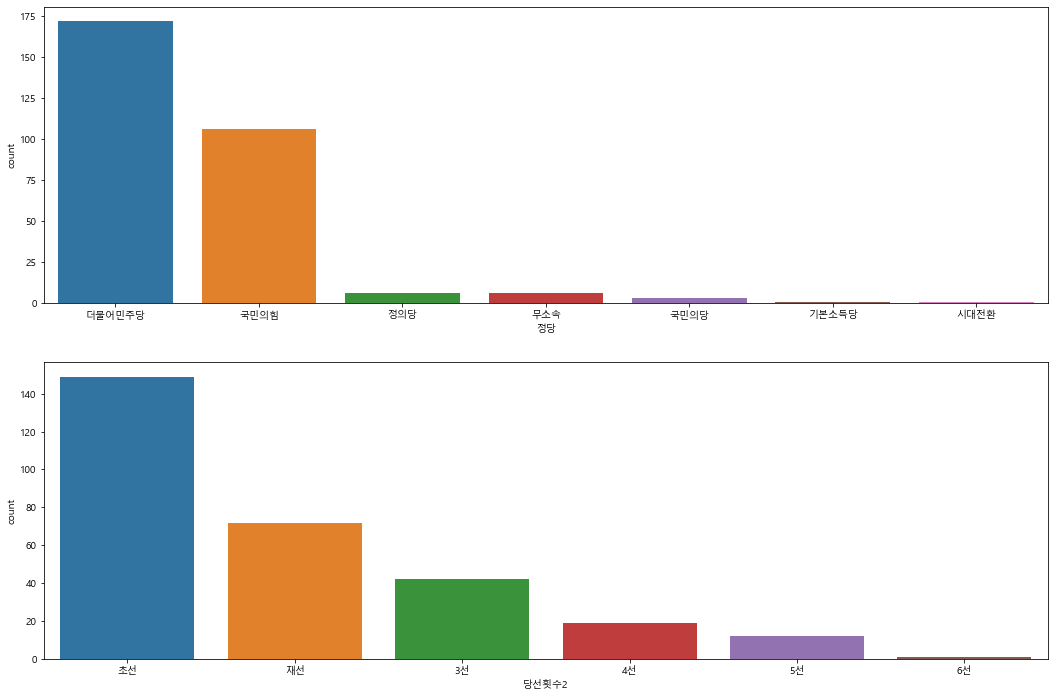

In [12]:
figure, (axes1,axes2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(18,12)

sns.countplot(data=member_df, x='정당', ax=axes1, order=member_df['정당'].value_counts().index)
sns.countplot(data=member_df, x='당선횟수2', ax=axes2, order=member_df['당선횟수2'].value_counts().index)

<AxesSubplot:xlabel='count', ylabel='선거구2'>

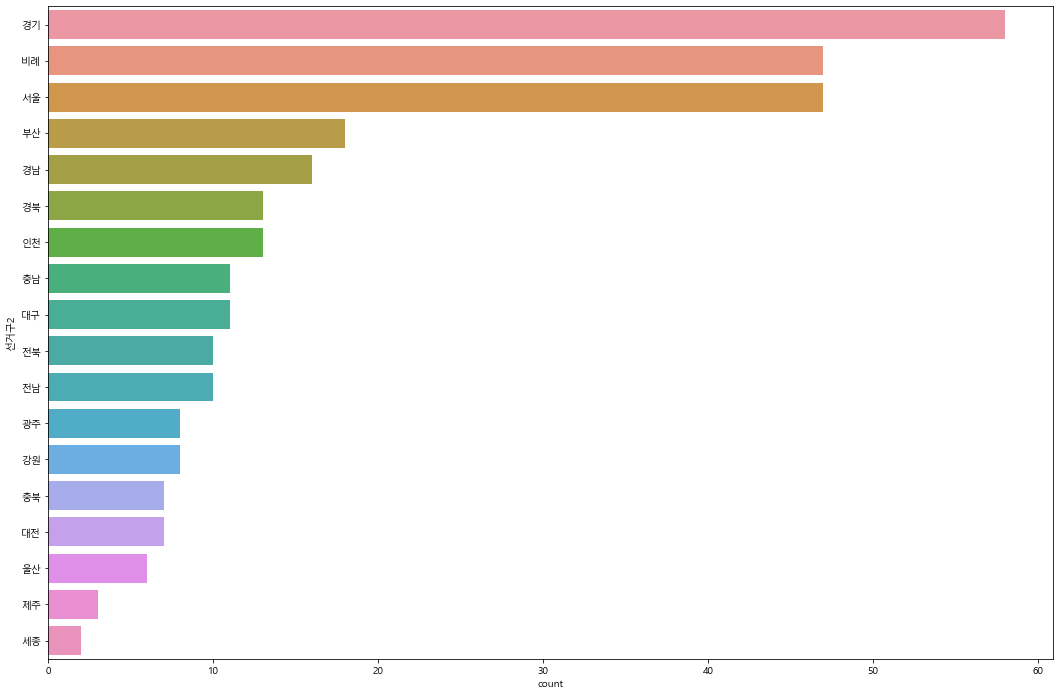

In [14]:
#선거구2 컬럼을 값으로  countplot 그리기
figure, axes1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18,12)
sns.countplot(data=member_df, y='선거구2', ax=axes1, order=member_df['선거구2'].value_counts().index)

<AxesSubplot:xlabel='정당', ylabel='나이'>

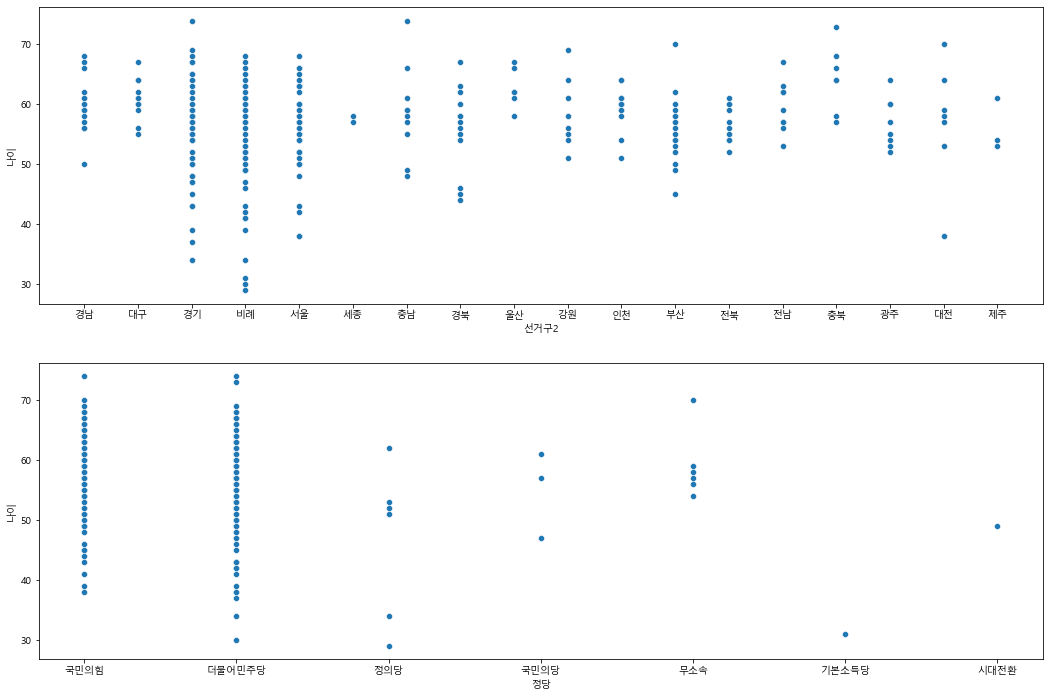

In [17]:
#seaborn의 Scatterplot(산점도) 그리기
#선거구2 와 나이 분포를 확인하기
#정당과 나이분포를 확인하기
figure, (axes1,axes2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(18,12)

sns.scatterplot(data=member_df, x='선거구2', y='나이', ax=axes1)
sns.scatterplot(data=member_df, x='정당', y='나이', ax=axes2)

In [ ]:
#seaborn 의 distplot() (히스토그램) 그릭
#나이 값의 분포를 확인하기
figure, axes1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18,12)